## River Turbidity Estimation using Sentinel-2 over Allahabad, India

## Table of Contents

* [Introduction](#1)
* [Necessary imports](#2)
* [Connect to your GIS](#3)
* [Get the data for analysis](#4)
* [Methodology](#5)
* [Prepare data for analysis](#6)
    * [Create geometry of aoi ](#7)
    * [Filter out sentinel-2 tiles](#8)
    * [Extract bands](#9)
* [Generate water bodies mask](#10)
    * [Create normalized difference water index raster](#11)
    * [Create binary raster](#12)
    * [Create water bodies mask](#13)
* [Normalized difference turbidity index](#14)
    * [Turbidity raster for water bodies ](#15)
* [Visualize results](#16)
    * [Get the results](#17)
    * [Interpretation of results](#20)
* [Conclusion](#21)
* [literature resources](#22)

## Introduction <a class="anchor" id="1"></a>

Turbidity represents how clear the water is or level of sediments in a water body. The main sources of turbidity are silt, algae, disposal of industrial waste i.e. mining,, factory waste, logging, etc. 

Allahabad is located at the confluence of Ganga and Yamuna river, it is one of the important cities of Hindu religion. Every day thousands of hindu divotees visits the city and disposes waste directly in the rivers, the small scale factories situated in the city also disposes the waste into rivers which causes water pollution. On 25th March 2020, lockdown was announced in India for controlling the COVID-19 spread which means total shutdown of industries and restricted human movement. The lockdown resulted in imporved river water quality hence less turbidity in rivers throughout the country.

Traditionally, the turbidity is analyzed by evaluating water samples taken during field measurements but field studies are expensive, time and labor intensive. During lockdown field surveys can't be perfomed and a good alternative of field surveys is satellite remote sensing data. Satellite data is able to cover both spatial and temporal variations in river turbidity levels. 

Sentinel-2 multispectral data is used in the current study to evaluate the changes in river turbidity due to COVID-19 lockdown.

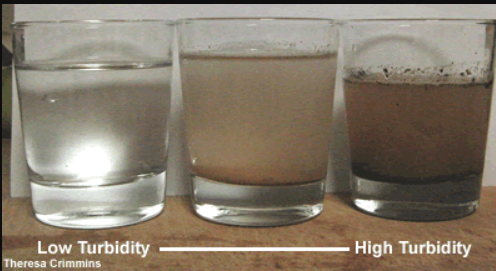

## Neccessary Imports <a class="anchor" id="2"></a>

In [1]:
import arcgis
from arcgis import *
from datetime import datetime
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.raster.analytics import convert_feature_to_raster, convert_raster_to_feature
from arcgis.raster.functions import extract_band, greater_than, clip, remap, colormap, stretch
from arcgis.features.analysis import dissolve_boundaries
from ipywidgets import HBox, VBox, Label, Layout

## Connect to your GIS <a class="anchor" id="3"></a>

In [2]:
from arcgis import GIS
gis2 = GIS("your_online_profile")
gis3 = GIS("your_enterprise_portal")

## Get the data for analysis <a class="anchor" id="4"></a>

[Sentinel-2 Views](https://www.arcgis.com/home/item.html?id=fd61b9e0c69c4e14bebd50a9a968348c) was used in the analysis, this multitemporal layer consists 13 bands with 10, 20, and 60m spatial resolution. The imagery layer is rendered on-the-fly and available for visualization and analytics.  This imagery layer pulls directly from the Sentinel-2 on AWS collection and is updated daily with new imagery.

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
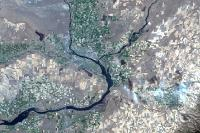

In [3]:
s2 = gis2.content.get('fd61b9e0c69c4e14bebd50a9a968348c')
sentinel = s2.layers[0]
s2

<Item title:"allahabad_aoi" type:Feature Layer Collection owner:arcgis_python>
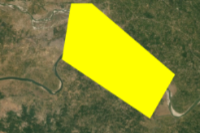

In [4]:
aoi1 = gis2.content.search('title:allahabad_aoi', 'Feature Layer Collection')[0]
aoi1

## Methodology <a class="anchor" id="5"></a>

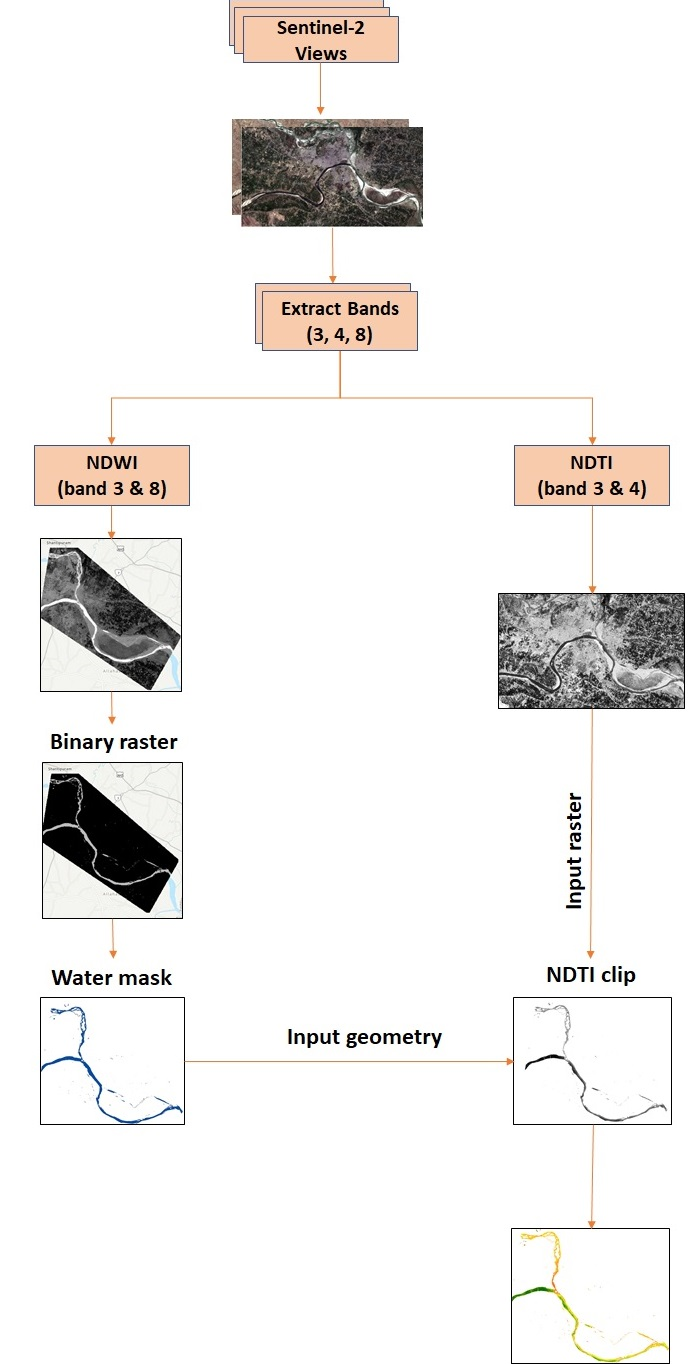

## Prepare data for analysis <a class="anchor" id="6"></a>

`Sentinel-2 Views` imagery layers consists data for whole world. First step is to filter out the data for before and during lockdwon of the study area which will be used in the analysis.

### Create geometry of aoi <a class="anchor" id="7"></a>

The geometry of aoi was created for filtering out the Sentinel-2 tiles for the study area.

In [5]:
aoi_layer = aoi1.layers[0]
aoi_feature = aoi_layer.query(where='fid=1')
aoi_geom = aoi_feature.features[0].geometry
aoi_geom['spatialReference'] = {'wkid':3857}

### Filter out sentinel-2 tiles  <a class="anchor" id="8"></a>

In [6]:
m = gis2.map('Allahabad, India', 11)
m

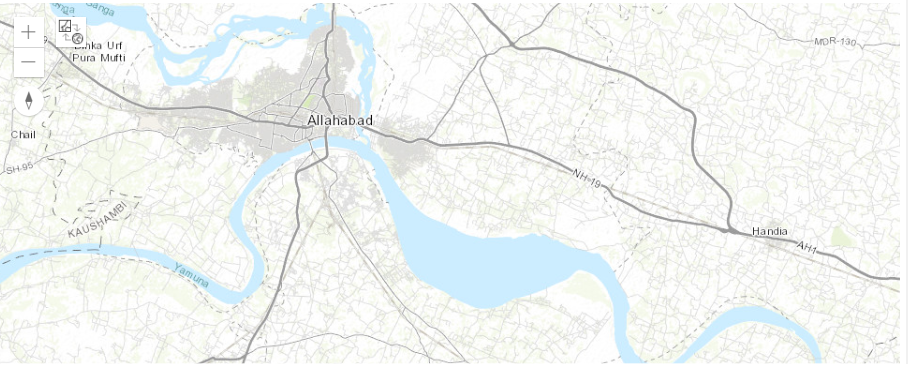

In [7]:
m.zoom_to_layer(aoi1)

#### Before lockdown

In [8]:
selected = sentinel.filter_by(where="(Category = 1)",
                             time=[datetime(2020, 3, 9), datetime(2020, 3, 11)],
                             geometry=arcgis.geometry.filters.intersects(aoi_geom))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

objectid     acquisitiondate                groupname  cloudcover  \
0  10003774 2020-03-09 05:21:34  20200309T052134_44RPP_0           0   
1  10003775 2020-03-09 05:21:38  20200309T052137_44RNP_0           0   
2  10003776 2020-03-09 05:21:49  20200309T052148_44RPN_0           0   
3  10003777 2020-03-09 05:21:52  20200309T052152_44RNN_0           0   

   dayofyear   shape_Length    shape_Area  \
0         69  411289.670549  1.001614e+10   
1         69  486307.001820  1.478067e+10   
2         69  357605.263126  6.801910e+09   
3         69  482722.878472  1.456361e+10   

                                               SHAPE     AcquisitionDate  
0  {"rings": [[[9225034.6736, 3024534.521499999],... 2020-03-09 05:21:34  
1  {"rings": [[[9138906.555100001, 3025524.7907],... 2020-03-09 05:21:38  
2  {"rings": [[[9198149.502, 2913289.101599999], ... 2020-03-09 05:21:49  
3  {"rings": [[[9137984.507800002, 2913901.974500... 2020-03-09 05:21:52

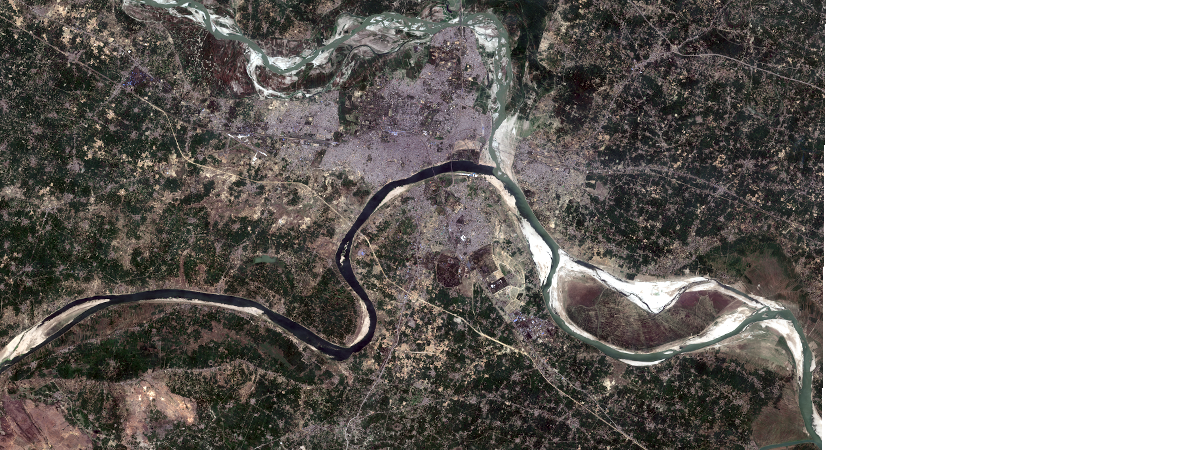

In [9]:
tile1 = sentinel.filter_by('OBJECTID=10003775')
tile1.extent = m.extent
tile1

In [10]:
tile1.save('s2_allbd_20200309', gis=gis3)

<Item title:"s2_allbd_20200309" type:Imagery Layer owner:admin>

#### During lockdown

In [11]:
selected = sentinel.filter_by(where="(Category = 1)",
                             time=[datetime(2020, 4, 9), datetime(2020, 4, 14)],
                             geometry=arcgis.geometry.filters.intersects(aoi_geom))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

objectid     acquisitiondate                groupname  cloudcover  \
0  10304744 2020-04-13 05:21:34  20200413T052134_44RPP_0      0.0207   
1  10481214 2020-04-13 05:21:38  20200413T052137_44RNP_0      0.0004   
2  10415547 2020-04-13 05:21:49  20200413T052148_44RPN_0      0.0000   
3  10415548 2020-04-13 05:21:52  20200413T052152_44RNN_0      0.0000   

   dayofyear   shape_Length    shape_Area  \
0        104  411250.271731  1.001344e+10   
1        104  486307.001820  1.478067e+10   
2        104  357554.873540  6.799904e+09   
3        104  482722.878472  1.456361e+10   

                                               SHAPE     AcquisitionDate  
0  {"rings": [[[9225023.4659, 3024534.6838000007]... 2020-04-13 05:21:34  
1  {"rings": [[[9138906.555100001, 3025524.7907],... 2020-04-13 05:21:38  
2  {"rings": [[[9198094.4782, 2913289.7751], [916... 2020-04-13 05:21:49  
3  {"rings": [[[9137984.507800002, 2913901.974500... 2020-04-13 05:21:52

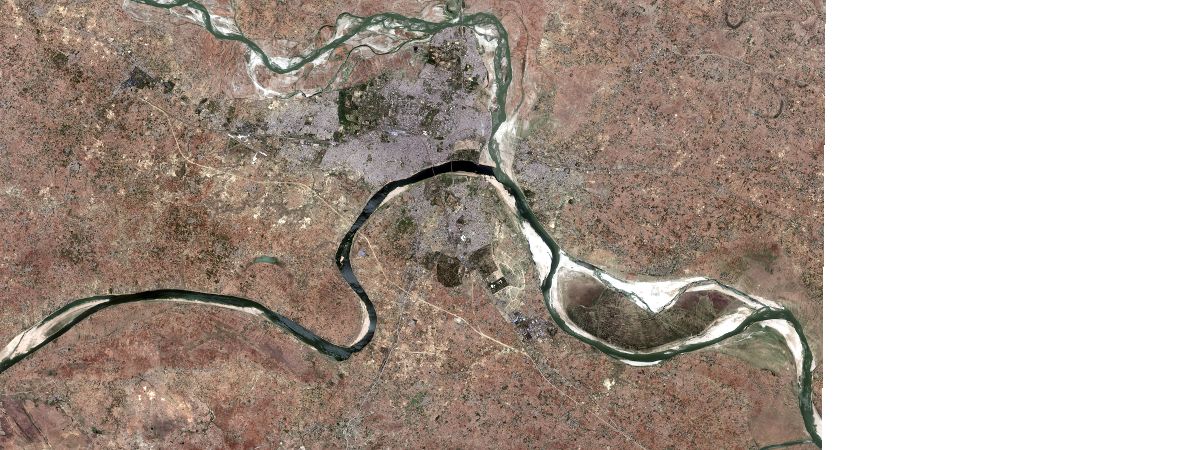

In [12]:
tile2 = sentinel.filter_by('OBJECTID=10481214')
tile2.extent = m.extent
tile2

In [13]:
tile2.save('s2_allbd_20200413', gis=gis3)

<Item title:"s2_allbd_20200413" type:Imagery Layer owner:admin>

In [14]:
tiles = gis3.content.search('title:s2_allbd_')
tiles

[<Item title:"s2_allbd_20200309" type:Imagery Layer owner:admin>,
 <Item title:"s2_allbd_20200413" type:Imagery Layer owner:admin>]

In [15]:
timestamps=set([layer.title[-8:] for layer in tiles])
timestamps=[t.strftime('%Y%m%d') for t in sorted([datetime.strptime(t,'%Y%m%d') for t in timestamps])]

### Extract bands<a class="anchor" id="9"></a>

Green (band 3), Red (band 4) and NIR (band 8) band was extracted from the Sentinel-2 tiles for further analysis.

In [16]:
def extract_green_band(tiles):
    print('extracting green band',end='\r')
    green_band = extract_band(tiles, [3])
    return green_band

In [17]:
def extract_red_band(tiles):
    print('extracting red band',end='\r')
    red_band = extract_band(tiles, [4])
    return red_band

In [18]:
def extract_nir_band(tiles):
    print('extracting nir band',end='\r')
    nir_band = extract_band(tiles, [8])
    return nir_band

## Generate water bodies mask<a class="anchor" id="10"></a>

### Create normalized difference water index raster<a class="anchor" id="11"></a>

Normalized difference water index (NDWI) is a satellite based index used for mapping and detecting the surface water bodies. Water absorbs electromagnetic radiation in visible to infrared spectrum, that is why Green and Near Infrared bands are used to detect the water bodies. In the current study, band 3 (green) and band 8 (NIR) of Sentinel-2 is used for generating NDWI raster. 

In [19]:
def create_ndwi_raster(green_band, nir_band, t, aoi_geom):
    print('creating ndwi raster',end='\r')
    ndwi = (green_band - nir_band)/(green_band + nir_band)
    c_ndwi = clip(ndwi, aoi_geom)
    ndwi_s = c_ndwi.save("ndwi_allbdt"+t, gis=gis3)
    ndwi_lyr = ndwi_s.layers[0]
    return ndwi_lyr

### Create binary raster<a class="anchor" id="12"></a>

Binary raster was created from NDWI raster using a threshold value. The binary raster consists two classes water and non water. Pixels with value greater than 0.03 are considered as water pixels. For creating binary raster [greater_than](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/greater-than.htm) function was used. The threshold value of **0.03** was used for creating the binary raster. Thesholding is important because NDWI is sensitive to built-up area and the pixel values for built-up will be positive similar to water bodies.

In [20]:
def create_binary_raster(ndwi_lyr, t):
    print('creating binary raster',end='\r')
    binary_raster = greater_than([ndwi_lyr, 0.03], 
                              extent_type='FirstOf', 
                              cellsize_type='FirstOf', 
                              astype='U16')
    binary_ras = binary_raster.save("binaryrast_"+t, gis=gis3)
    binaryras_lyr = binary_ras.layers[0]
    return binaryras_lyr

### Create water bodies mask<a class="anchor" id="13"></a>

#### Convert binary raster to feature layer

The binary rasters were converted to feature layer for extracting the boundaries of water bodies.

In [21]:
def create_binary_poly(binaryras_lyr, t):
    print('creating binary feature layer',end='\r')
    binary_poly = convert_raster_to_feature(binaryras_lyr, 
                                          field='Value', 
                                          output_type='Polygon', 
                                          simplify=True, 
                                          output_name='binary_poly'+t, 
                                          gis=gis3)
    return binary_poly

#### Extract water polygons

In the feature layer 'gridcode=0' represents non water class and 'gridcode=1' represents water class. Water polygons were selected using the `query` function from the dataframe of feature layer. A new feature layer was created using `gis.content.import` function which will only consist the water polygons.

In [22]:
def extract_water_polygons(binary_poly, t):
    print('extracting water polygon',end='\r')
    dfm=binary_poly.layers[0].query('gridcode=1').sdf 
    water_poly=gis3.content.import_data(dfm, title='wpoly'+t)
    return water_poly

The features of `water_poly` were dissolved using [dissolve_boundaries](https://pro.arcgis.com/en/pro-app/tool-reference/feature-analysis/dissolve-boundaries.htm) function. The features were dissolved on the basis of `gridcode` column.

In [23]:
def dissolve_water_features(water_poly, t):
    print('dissolving water features',end='\r')
    diss_f = dissolve_boundaries(water_poly,
                                 dissolve_fields=['gridcode'], 
                                 output_name='dissolve_poly'+t, 
                                 gis=gis3,  
                                 multi_part_features=True)
    return diss_f

###  Normalized difference turbidity index<a class="anchor" id="14"></a>

Normalize Differece Turbidity Index (NDTI) is a satellite driven index which is used to estimate the turbidity in water bodies.  the electromagnetic radiation reflectance is higher in green spectrum than the red spectrum for clear water. According to literature, with increase in turbidity the reflectance of red spectrum also increases. In the current study Sentinel-2  green (band 3) and red (band 4) bands were used to create the NDTI raster.

In [24]:
def create_ndti_ras(red_band, green_band, t):
    print('creating ndti raster',end='\r')
    ndti = (red_band - green_band)/(red_band + green_band)
    ndti_s = ndti.save("ndti_allbd"+t, gis=gis3)
    ndti_lyr = ndti_s.layers[0]
    return ndti_lyr

### Turbidity raster for water bodies<a class="anchor" id="15"></a>

To extract the turbidity values only for water pixels, first step is to create geometry of `dissolve_f`:

In [25]:
def create_water_geom(diss_f):
    print('creating geometry',end='\r')
    aoi2_layer = diss_f.layers[0]
    aoi2_feature = aoi2_layer.query(where='gridcode=1')
    aoi2_geom = aoi2_feature.features[0].geometry
    aoi2_geom['spatialReference'] = {'wkid':3857}
    return aoi2_geom

Second step is to [clip](https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html#clip) the NDTI rasters with the geometry of `dissolve_f` raster.

In [26]:
def clip_water_ndti_ras(ndti_lyr, aoi2_geom, t):
    print('clipping ndti raster with water boundary',end='\r')
    clip_ndti = clip(ndti_lyr, aoi2_geom)
    clip_ndti_ras = clip_ndti.save("cl_ndti"+t, gis=gis3)
    return clip_ndti_ras

Third step is to apply [colormap](https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html?highlight=colormap#arcgis.raster.functions.colormap) for vizualization of results.

In [27]:
def stretch_ndti_ras(clip_ndti_ras, t):
    print('clipping stretch ndti raster',end='\r')
    stretch_rs = colormap(stretch(clip_ndti_ras.layers[0], 
                                  stretch_type='PercentClip', 
                                  min=0, 
                                  max=255),
                          colormap_name="Condition Number")
    ndti_cmap = stretch_rs.save("ndti_cmapr"+t, gis=gis3)
    return stretch_ras

All the above mentioned functions were looped together for time series analysis.

In [28]:
for t in timestamps:
    
    print(f'Processing layers for :{t}\n')
    tiles = gis3.content.search(f's2_allbd_{t}')[0].layers[0]
    green_band=extract_green_band(tiles=tiles)
    red_band=extract_red_band(tiles=tiles) 
    nir_band=extract_nir_band(tiles=tiles) 
    ndwi_lyr=create_ndwi_raster(green_band=green_band, nir_band=nir_band, t=t, aoi_geom=aoi_geom)
    binaryras_lyr=create_binary_raster(ndwi_lyr=ndwi_lyr, t=t)
    binary_poly=create_binary_poly(binaryras_lyr=binaryras_lyr, t=t)
    water_poly=extract_water_polygons(binary_poly=binary_poly, t=t)
    diss_f=dissolve_water_features(water_poly=water_poly, t=t)
    ndti_lyr=create_ndti_ras(green_band=green_band, red_band=red_band, t=t)
    aoi2_geom=create_water_geom(diss_f=diss_f)
    clip_ndti_ras=clip_water_ndti_ras(ndti_lyr=ndti_lyr, aoi2_geom=aoi2_geom, t=t)
    stretch_ras=stretch_ndti_ras(clip_ndti_ras=clip_ndti_ras, t=t)
    print(f'Processing completed for :{t}\n')

Processing layers for :20200309

Processing completed for :20200309

Processing layers for :20200413

Processing completed for :20200413



## Visualize results<a class="anchor" id="16"></a>

### Get the results<a class="anchor" id="17"></a>

The NDTI rasters and their corresponding Sentinel-2 tiles were taken for visualization.

In [29]:
ras1 = gis3.content.search('ndti_cmap20200309', 'Imagery Layer')[0]
ras2 = gis3.content.search('ndti_cmap20200413', 'Imagery Layer')[0]
ras3 = gis3.content.search('s2_allbd_20200309', 'Imagery Layer')[0]
ras4 = gis3.content.search('s2_allbd_20200413', 'Imagery Layer')[0]

### Create map widgets<a class="anchor" id="17"></a>

4 map wigets were created representing the NDTI raster and Sentinel-2 for 9th March (before lockdown) and 13th April (during lockdown).

In [30]:
map1 = gis3.map("Allahabad, India", 12)
map1.basemap = 'national-geographic'
map1.add_layer(ras1)
map2 = gis3.map("Allahabad, India", 12)
map2.basemap = 'national-geographic'
map2.add_layer(ras2)
map3 = gis3.map("Allahabad, India", 12)
map3.add_layer(ras3)
map4 = gis3.map("Allahabad, India", 12)
map4.add_layer(ras4)

### Synchronize web maps<a class="anchor" id="18"></a>

All the maps were synchronized with each other using [MapView.sync_navigation](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. It will help in comparing the river turbidity before and during lockdown. Detailed description about advanced map widget options can be refered from [here](https://developers.arcgis.com/python/guide/advanced-map-widget-usage/)

In [31]:
map1.sync_navigation(map2)
map2.sync_navigation(map3)
map3.sync_navigation(map4)

### Set the map layout<a class="anchor" id="19"></a>

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [32]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1,hb2=HBox([Label('NDTI (09-Mar-20)'),Label('NDTI (13-Apr-20)')]),\
                HBox([Label('Sentinel-2 (09-Mar-20)'),Label('Sentinel-2 (13-Apr-20)')])
hb1.layout,hb2.layout=hbox_layout,hbox_layout

### Interpretation of results<a class="anchor" id="20"></a>

In [33]:
VBox([hb1,HBox([map1,map2]),hb2, HBox([map3,map4])])

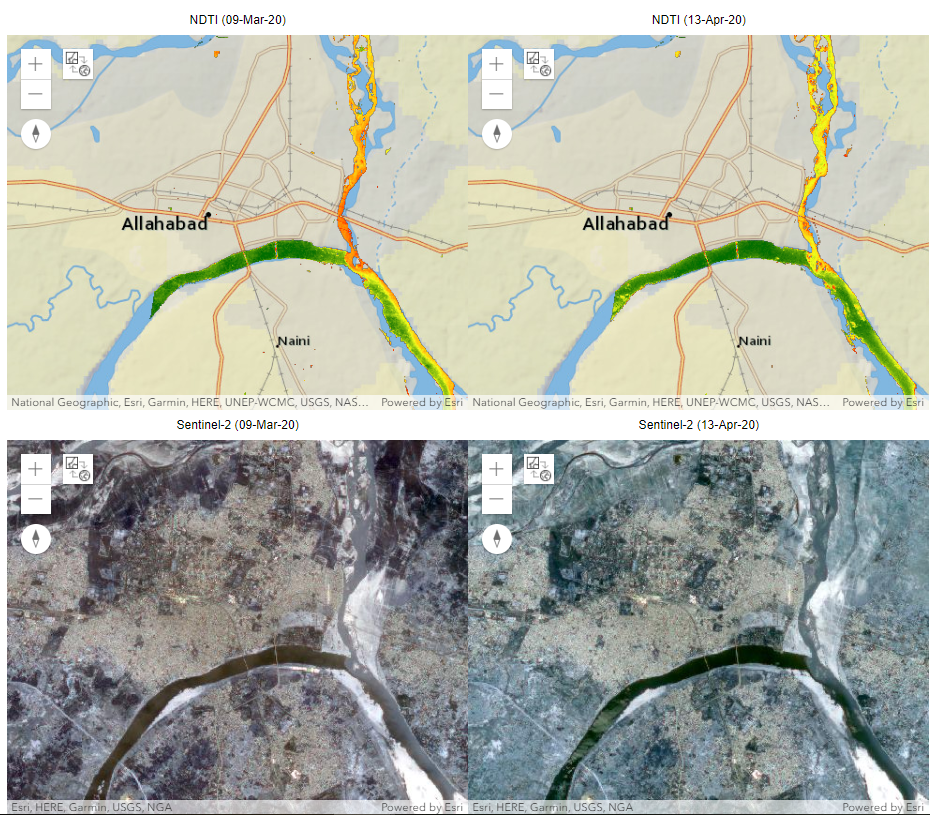

The map widgets shows the spatio-temporal variation in river turbidity due to Covid-19 lockdown. In the current study, Sentinel-2 data has been used for Allahabad, India. The turbidity of Ganga and Yamuna river was analyzed. The two dates which were used in the analysis are 9th march 2020 which represents before lockdown situation and 13th April 2020 represents during the lockdown situation. Red pixels in the map represents very high turbidity and the turbidity decreases from Red to Green. Orange and Yellow pixels represents high and moderate turbidity. The turbidity declined in both Ganga and Yamuna river during lockdown. The tubidity declined in Yamuna but the changes are much more visible in Ganga river. Ganga river shows high to moderate turbidity before lockdown, whole river stretch only has red to yellow pixels but on 13th April, the river has green pixels. The turbidity at the Sangam also shows decline in turbidity. After Sangam the river stretch mostly has green pixels which represents low turbidity.

## Conclusion<a class="anchor" id="21"></a>

Ganga and Yamuna river comes under world's most polluted river and at Allahabad both river meets. Due to one of the religious center of Hindus all the religious wastes are disposed directly in the rivers which causes water pollution and high turbidity. To control the spread COVID-19 Epidemic lock down was started from 18th March 2020 and all the movement and  industries were stopped. Due to which the the river turbidity levels decreases throughout the country. Sentinel-2 data was used for studying the spatial variations of river turbidity over time. The results of the study suggests that the turbidity levels decreased due to COVID-19 lockdown. The same methodology can be used to study the changes in river turbidity for different regions with Sentinel-2 data using ArcGIS platform.

## Literature resources<a class="anchor" id="22"></a>

|Literature | Source | Link |
| -| - |-|
| Research Paper   | Changes in turbidity along Ganga River using Sentinel-2 satellite data during lockdown associated with COVID-19|https://www.tandfonline.com/doi/full/10.1080/19475705.2020.1782482|
| Research Paper   |Water Turbidity Assessment in Part of Gomti River Using High Resolution Google Earth’s Quickbird satellite data|https://geospatialworldforum.org/2011/proceeding/pdf/Shivangifullpaper.pdf|